In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib

import matplotlib.pyplot as plt

SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

T = 20
L = 1000
N = 100

In [2]:
x = np.empty((N, L), 'int32')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float32')

# load data and make training set
input = torch.from_numpy(data[3:, :-1])
target = torch.from_numpy(data[3:, 1:])
print (input.shape)
print (target.shape)

test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])
print (test_input.shape)
print (test_target.shape)

torch.Size([97, 999])
torch.Size([97, 999])
torch.Size([3, 999])
torch.Size([3, 999])


In [3]:
class Sequence(nn.Module):
    def __init__(self, hdim):
        super(Sequence, self).__init__()
        self.rnn = nn.RNNCell(1, hdim)
        self.linear = nn.Linear(hdim, 1)
        self.hdim = hdim

    def forward(self, input, future = 0):
        outputs = []
        
        # create a tensor for the hidden state initialized to zero
        h_t = torch.zeros((input.size(0),self.hdim))

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            # apply the RNN
            h_t = self.rnn(input_t,h_t)
            # apply the linear layer 
            output = self.linear(h_t)
            outputs.append(output)
        for i in range(future):# if we should predict the future
            
            # apply the RNN to the last value
            h_t = self.rnn(outputs[-1],h_t)
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [4]:
# build the model with 10 hidden units
seq = Sequence(100)

criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

STEP: 0 loss: 0.00017368931730743498 test loss: 0.0001237814867636189


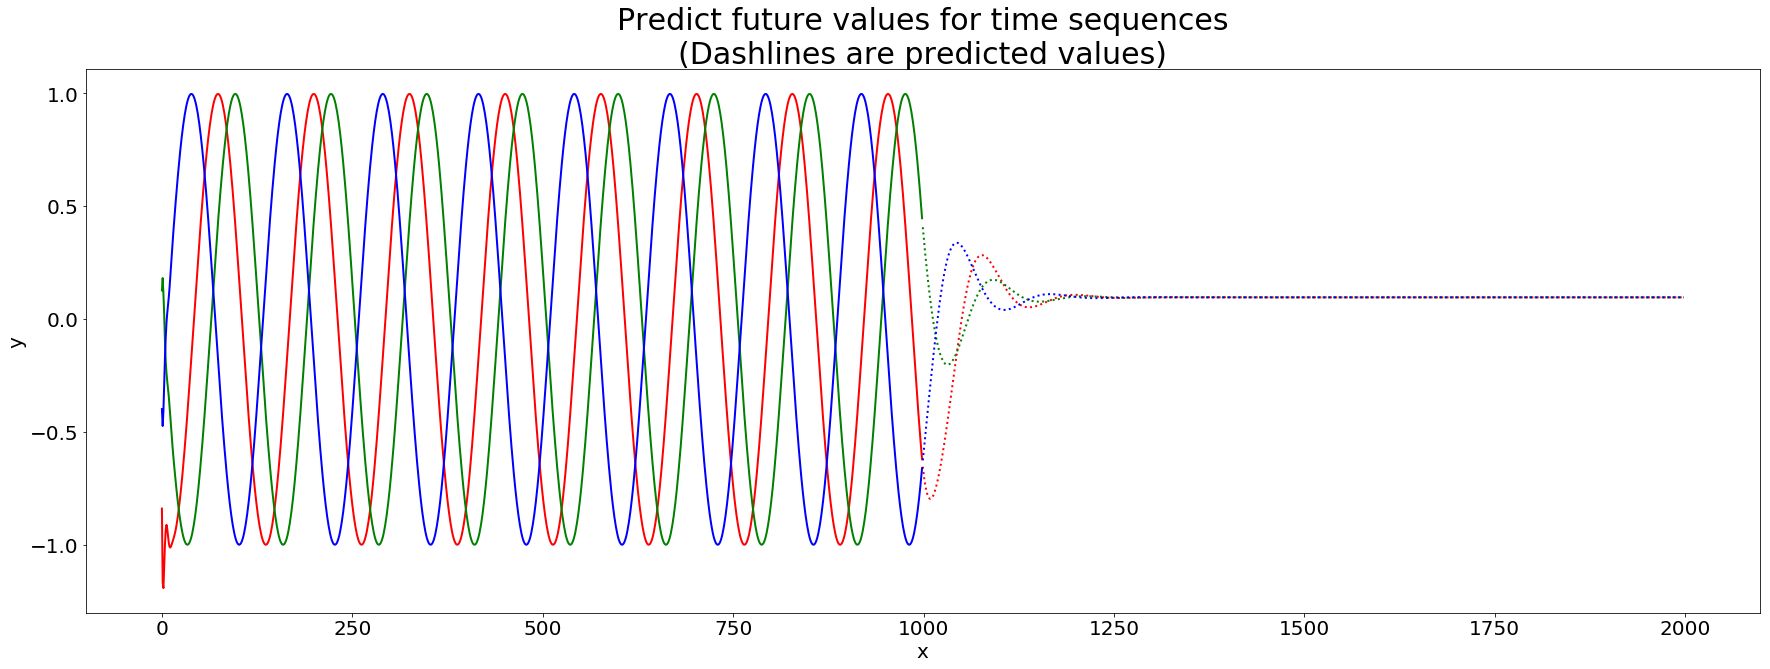

STEP: 1 loss: 8.80839434103109e-0554 test loss: 0.00010282199218636379


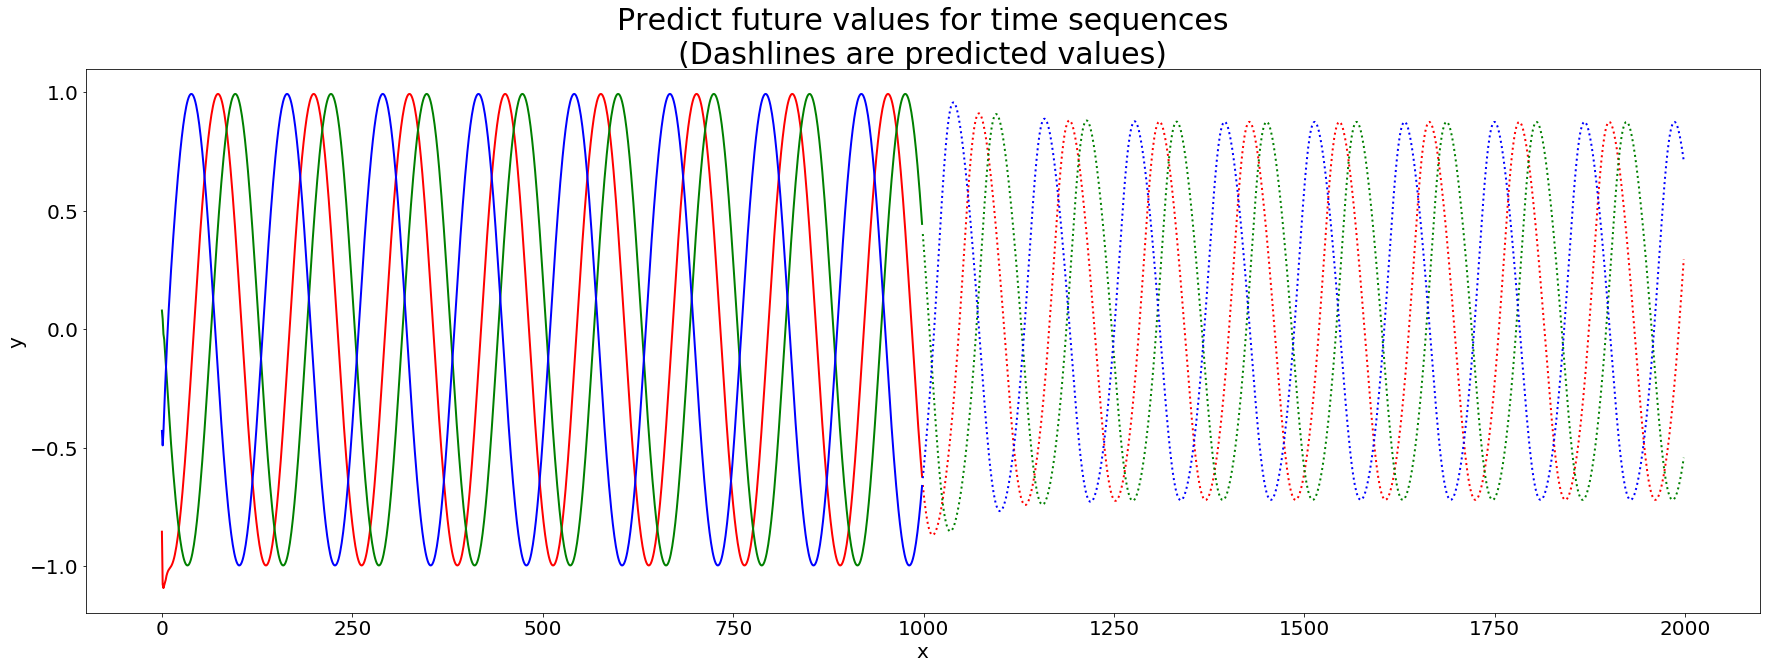

STEP: 2 loss: 0.00012246536789461975 test loss: 4.230856575304642e-05


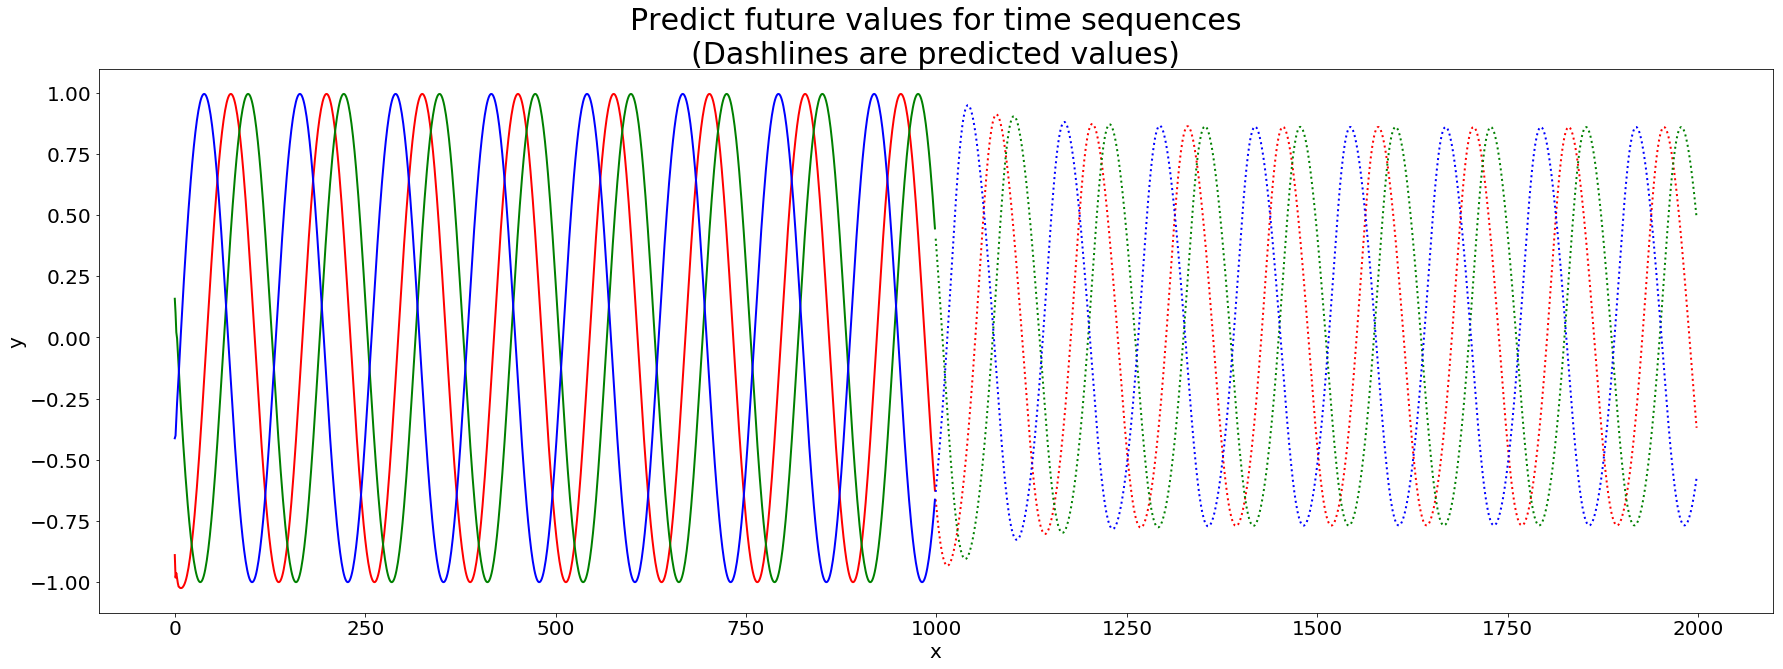

STEP: 3 loss: 4.16521834267769e-0555 test loss: 4.140571036259644e-05


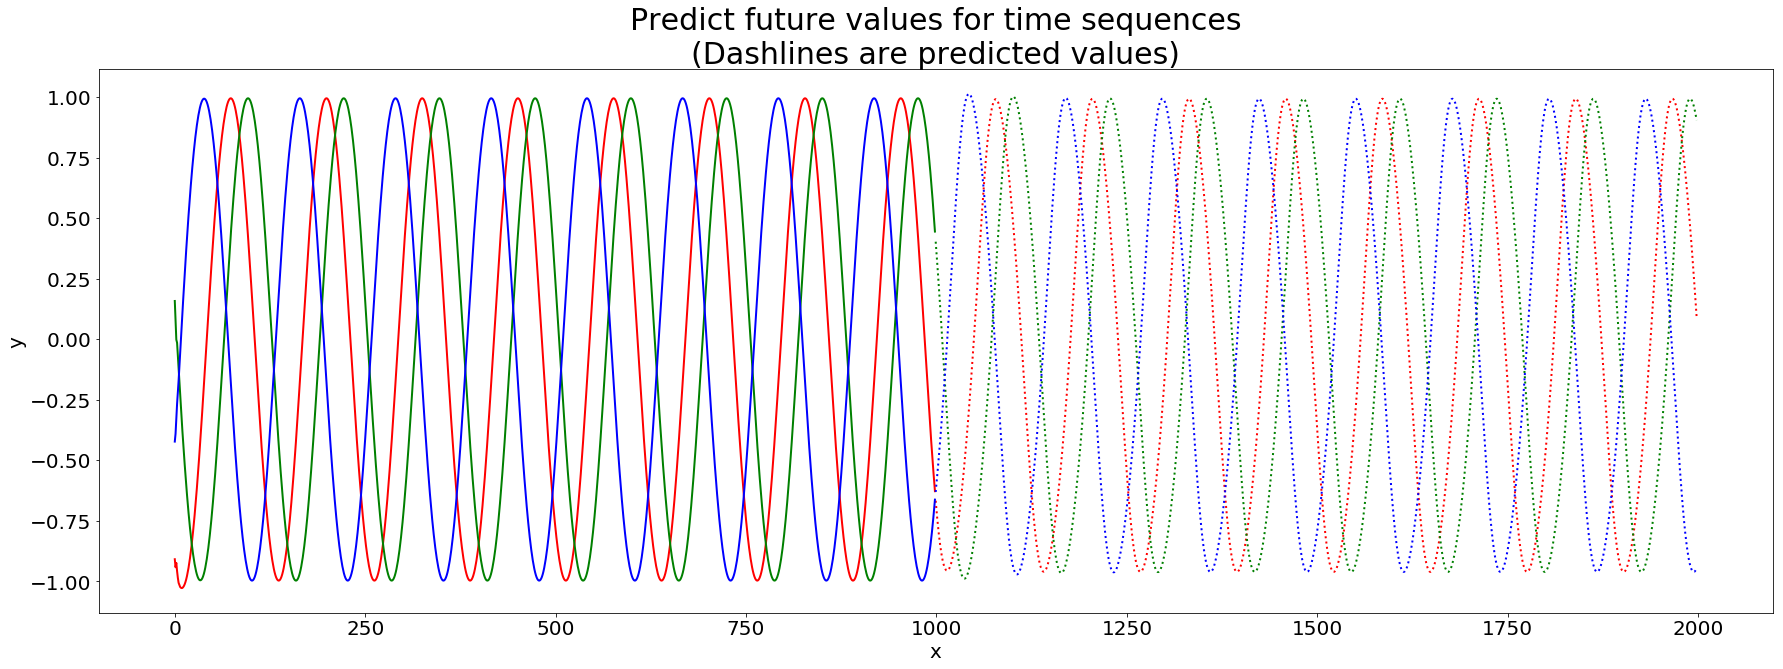

STEP: 4 loss: 3.382447175681591e-055 test loss: 3.318765448057093e-05


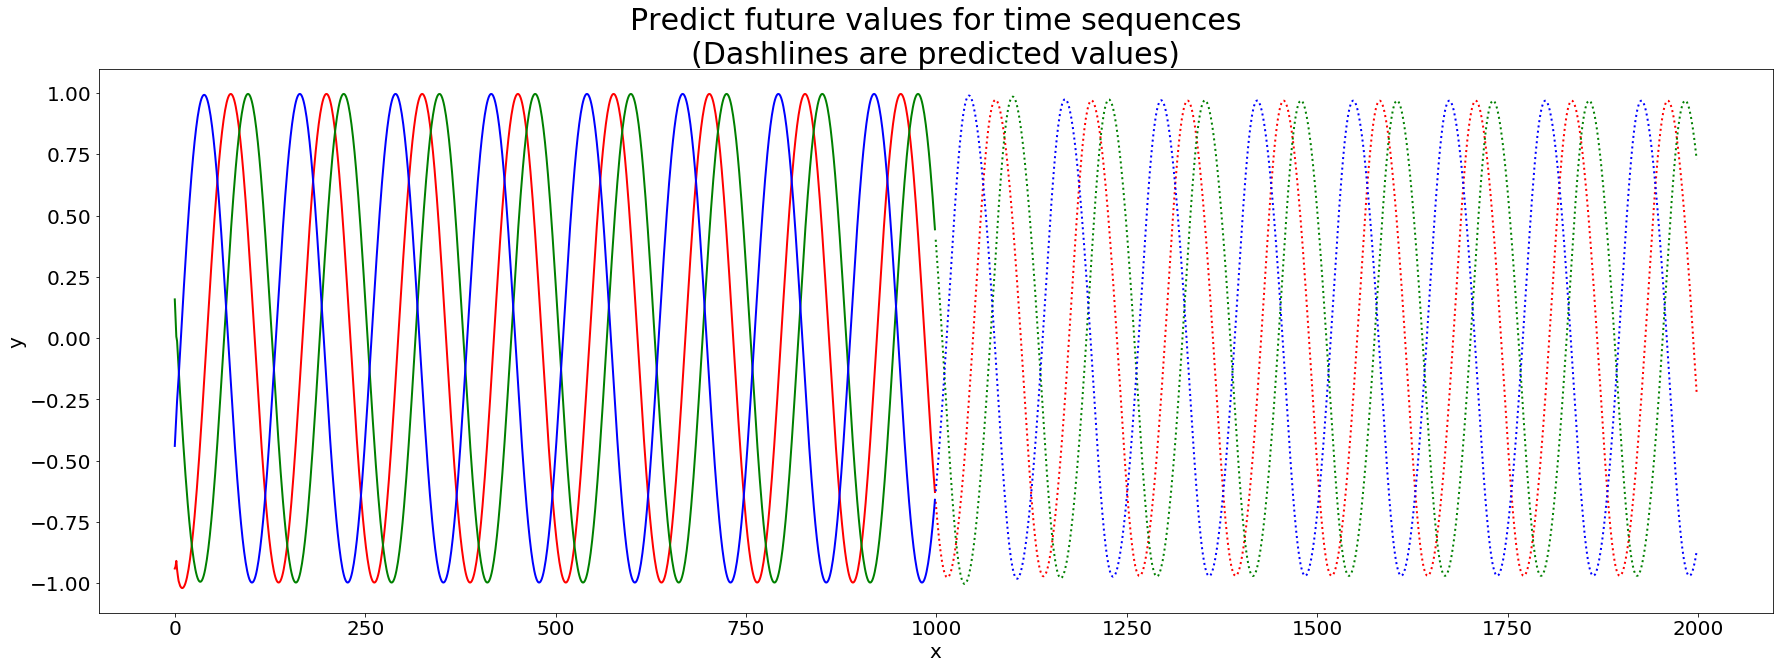

STEP: 5 loss: 3.1700947147328407e-05 test loss: 3.37646524712909e-05


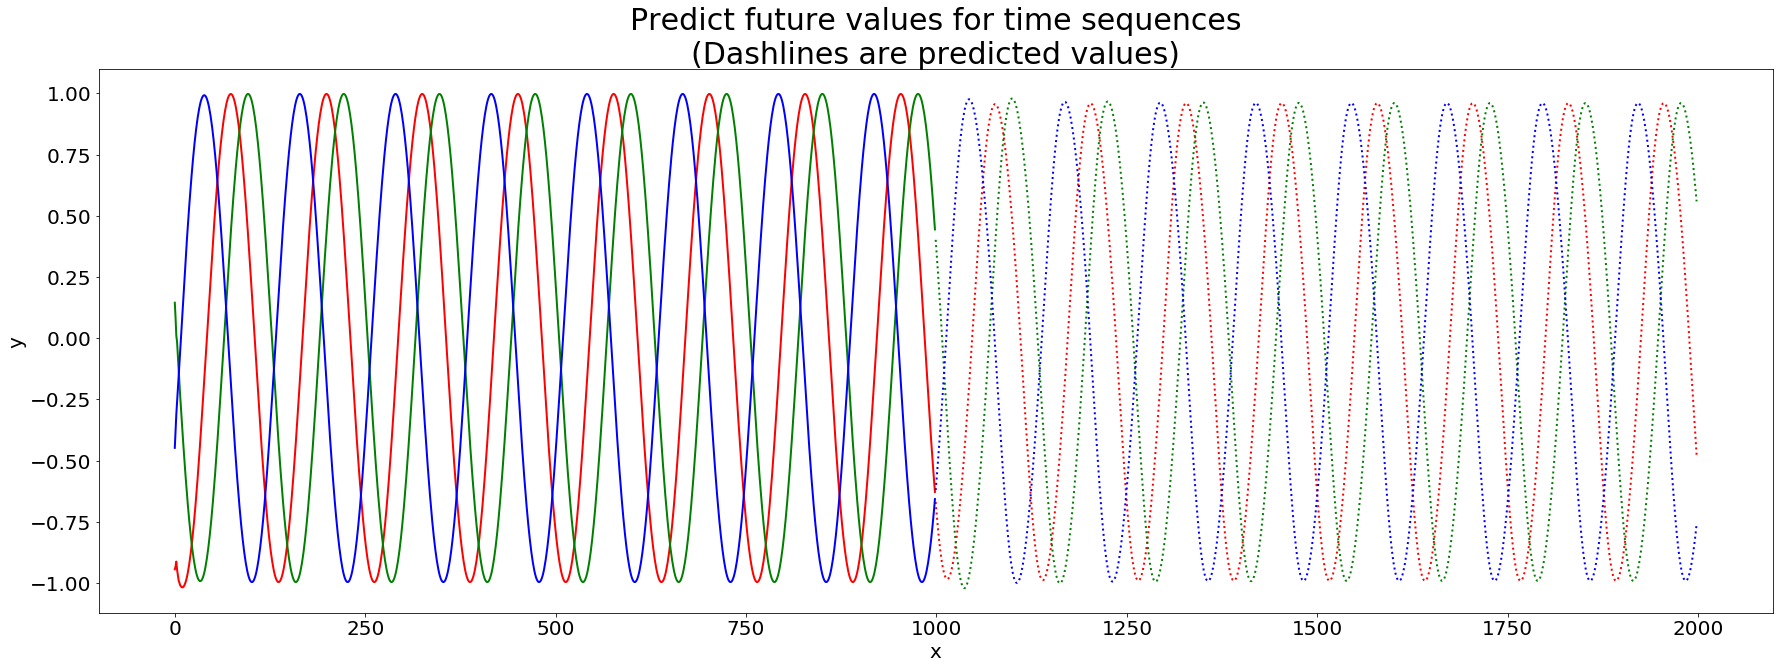

STEP: 6 loss: 3.093243867624551e-055 test loss: 3.2808122341521084e-05


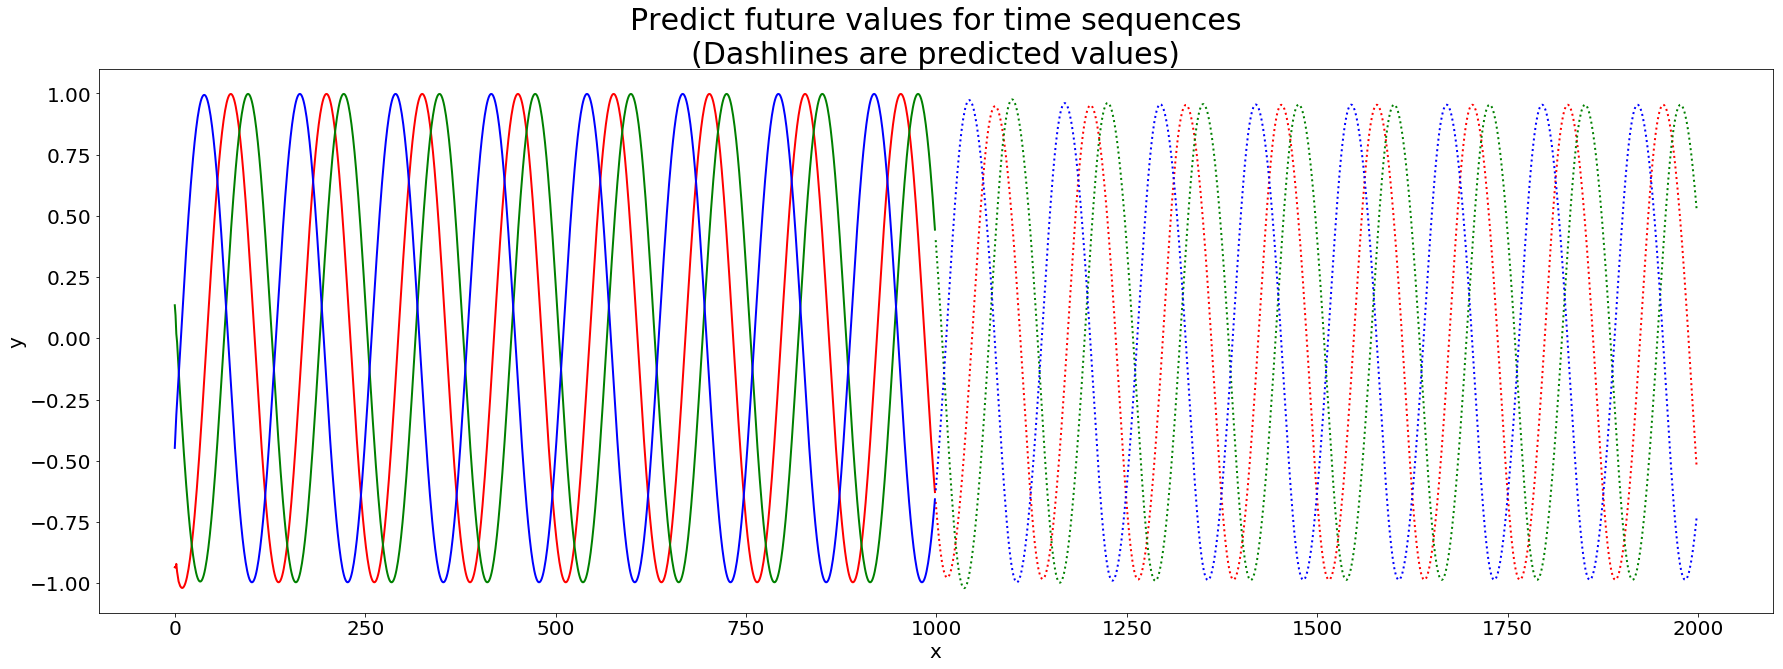

STEP: 7 loss: 2.994875467265956e-055 test loss: 3.181658757966943e-05


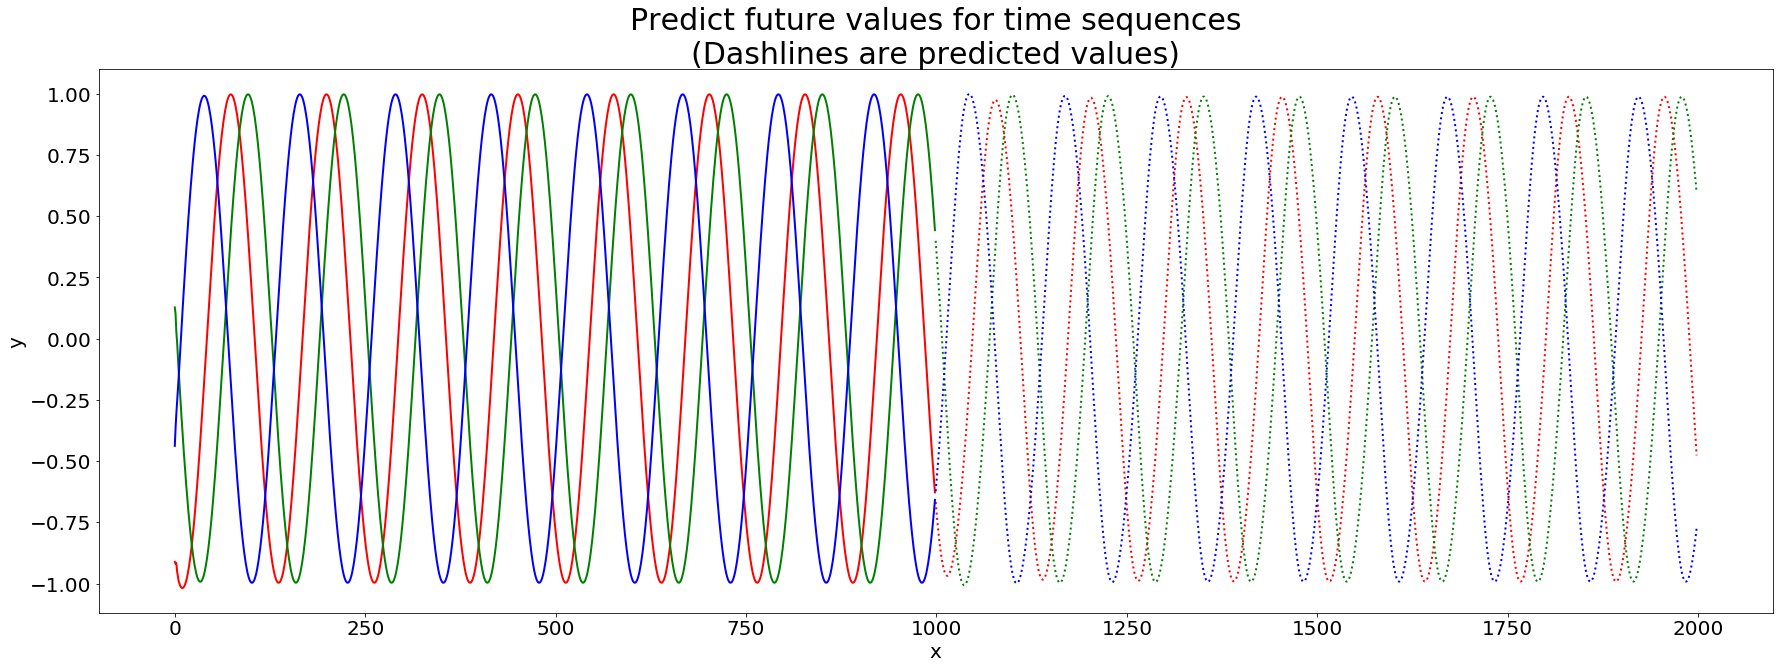

STEP: 8 loss: 2.97523001790978e-0505 test loss: 3.737027509487234e-05


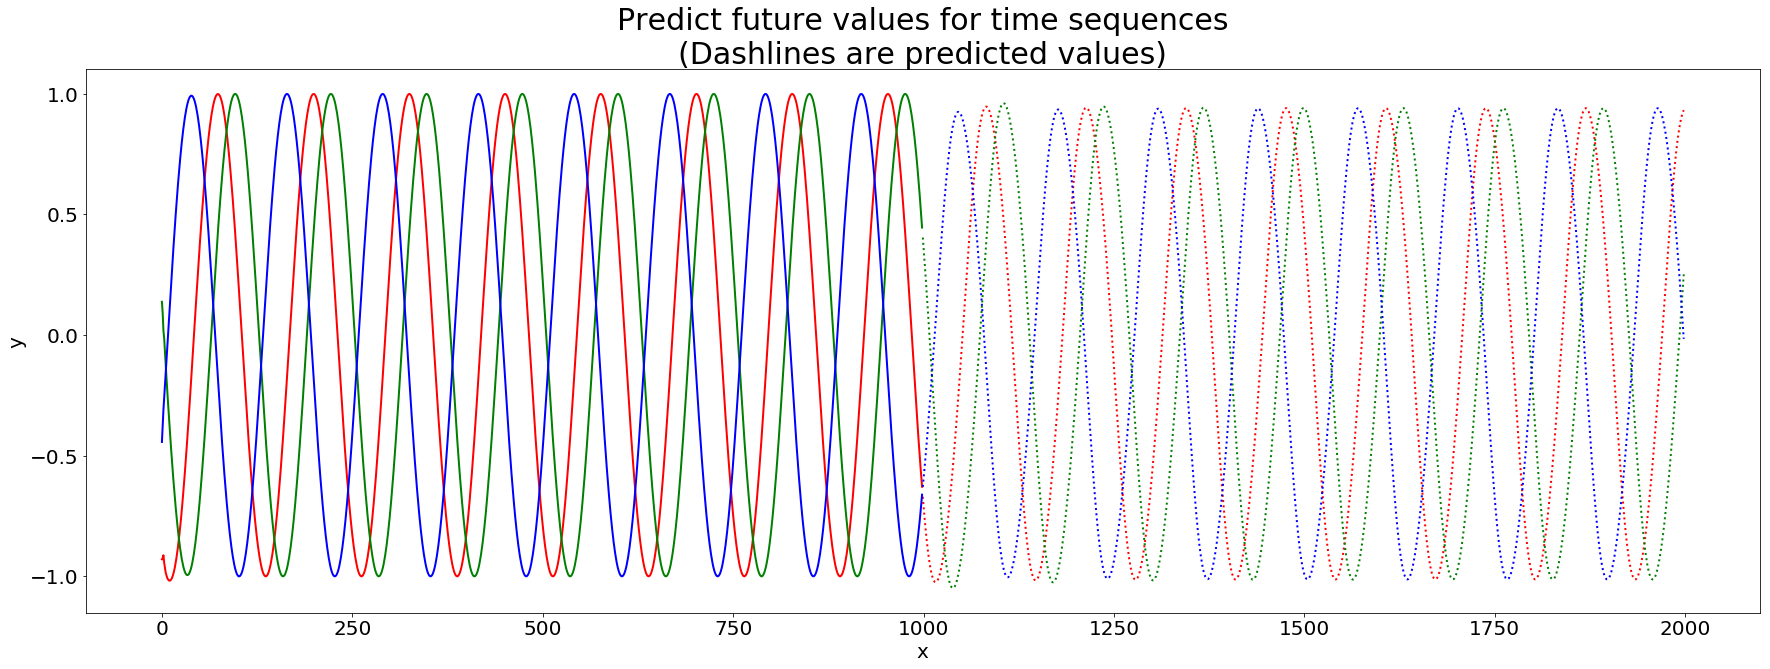

STEP: 9 loss: nan.273071289062579845 test loss: nan


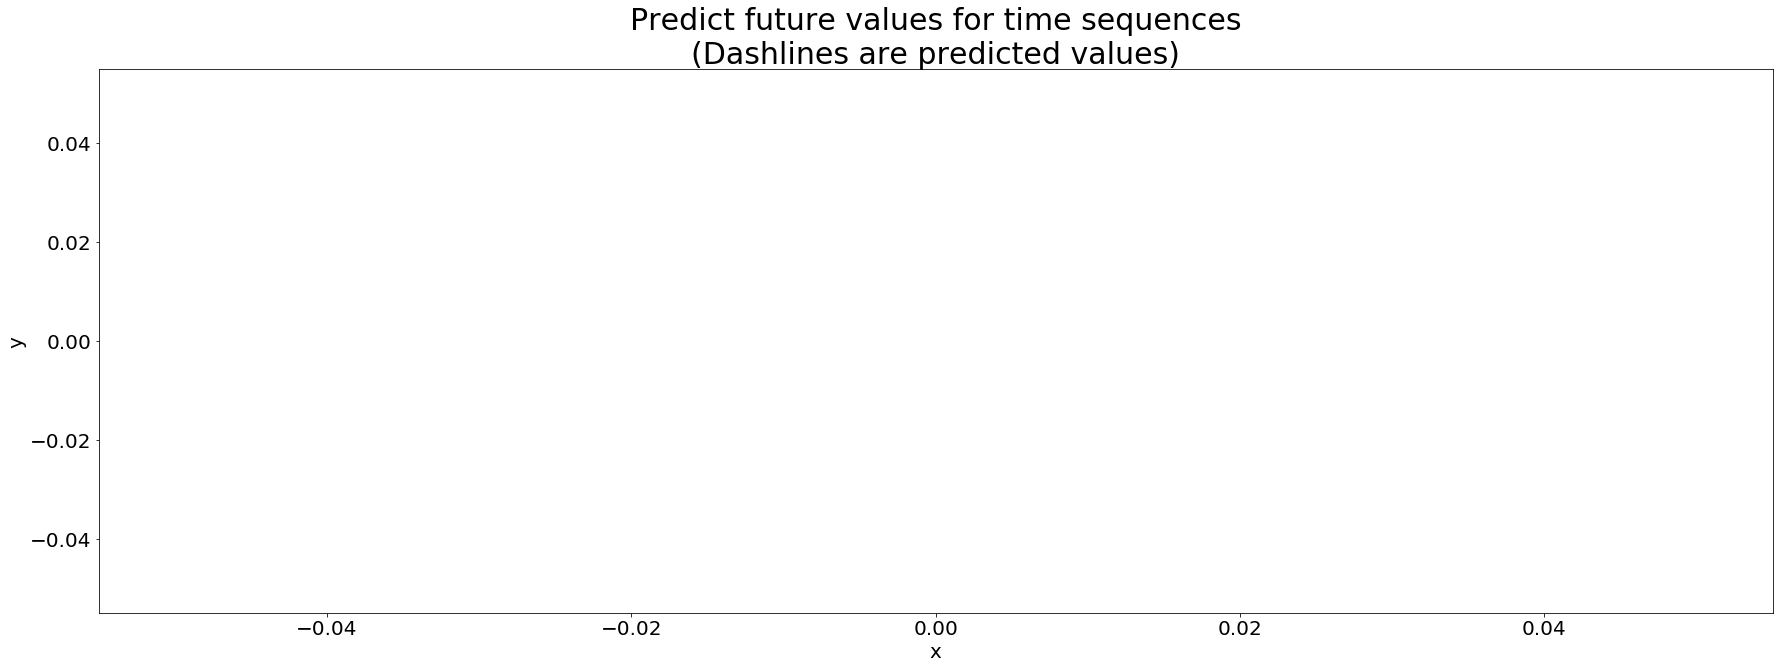

STEP: 10 loss: nan test loss: nan


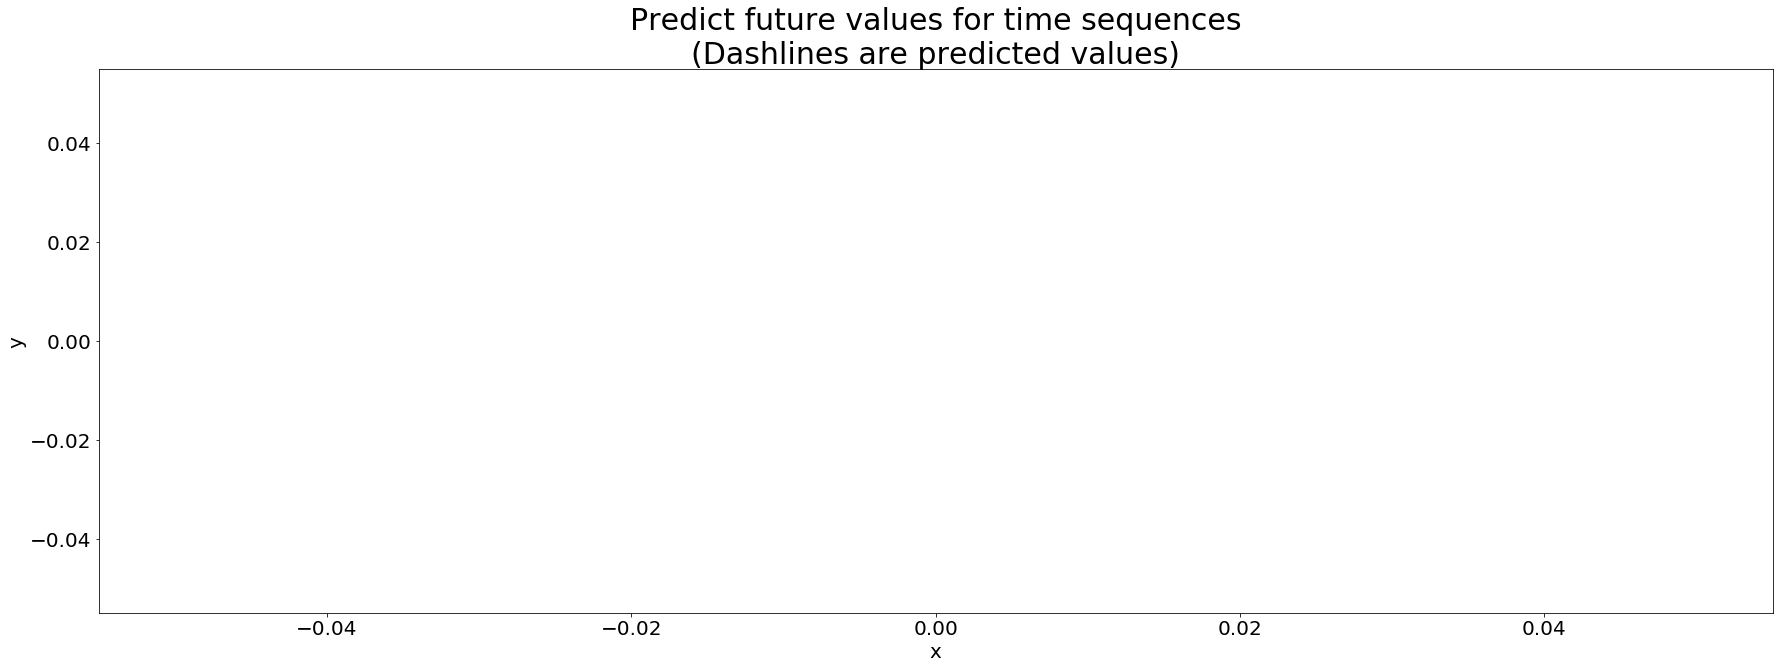

STEP: 11 loss: nan test loss: nan


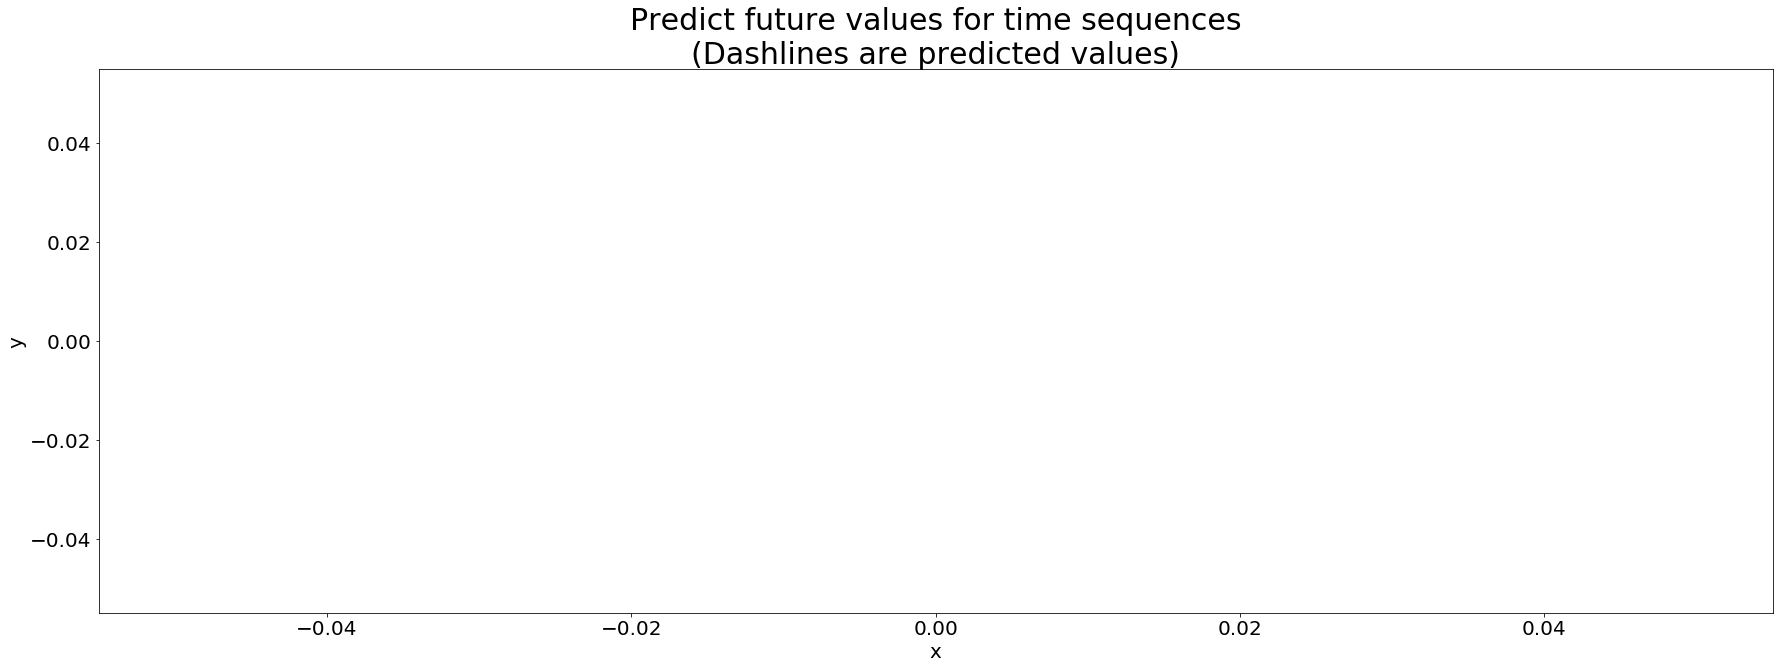

STEP: 12 loss: nan test loss: nan


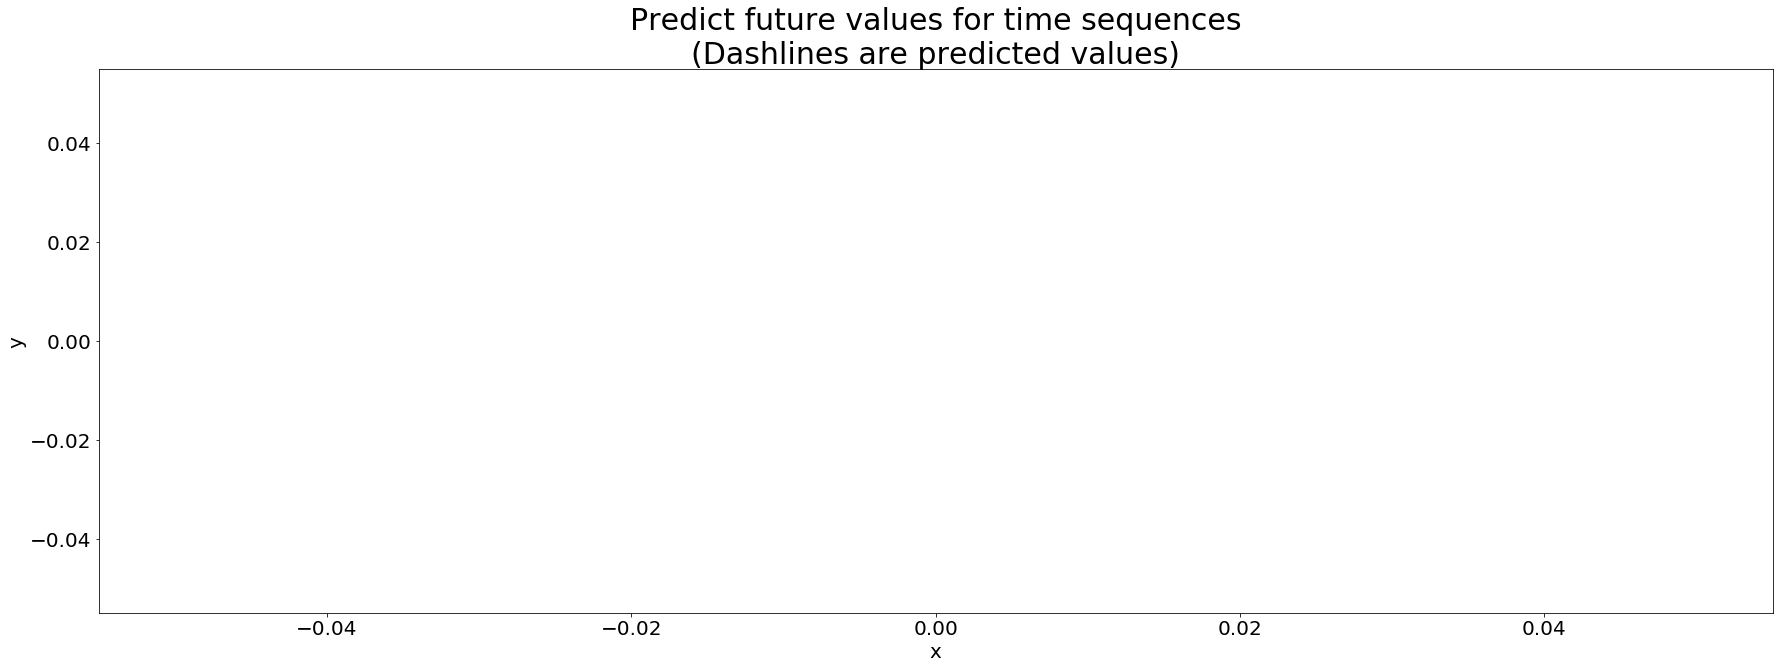

STEP: 13 loss: nan test loss: nan


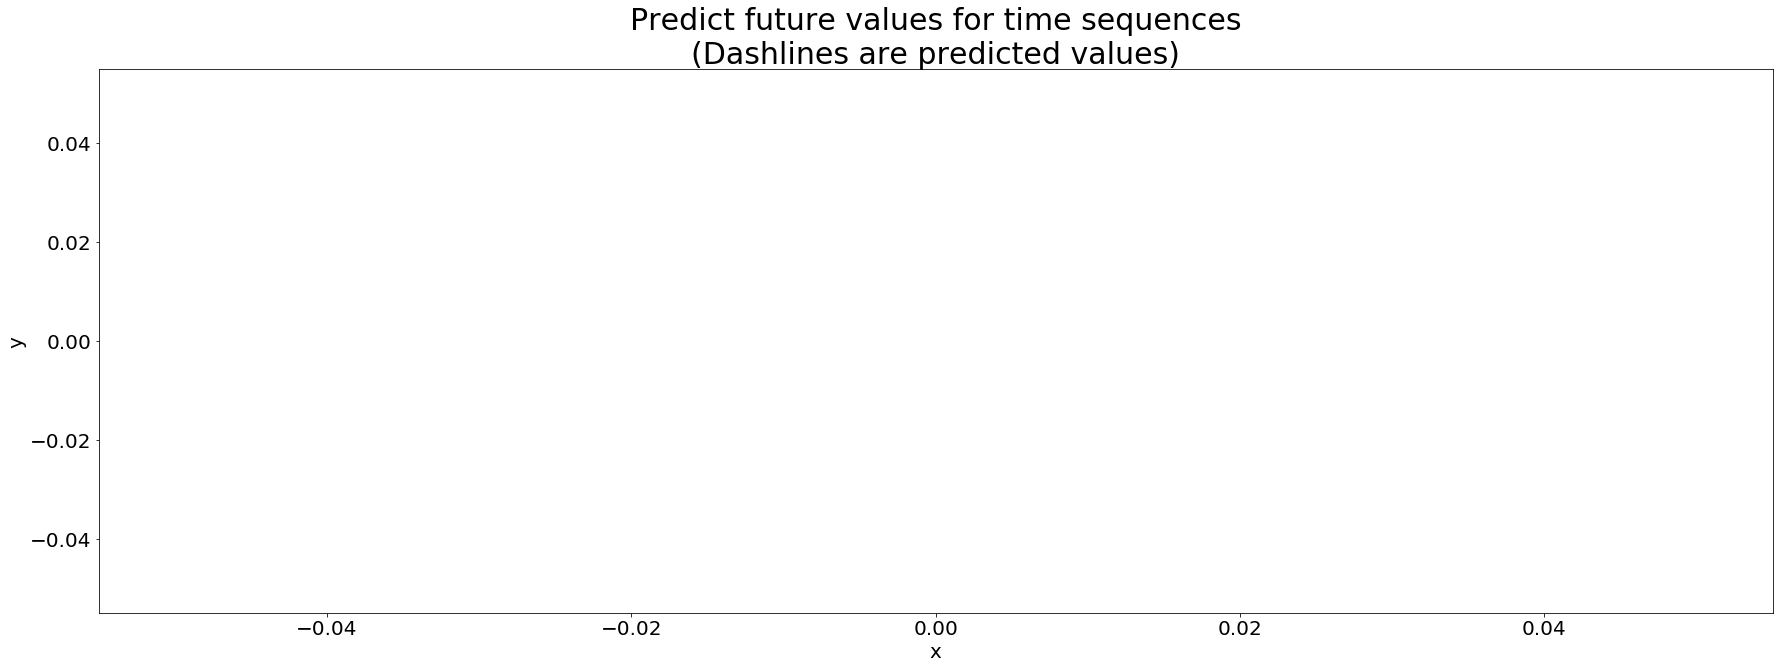

STEP: 14 loss: nan test loss: nan


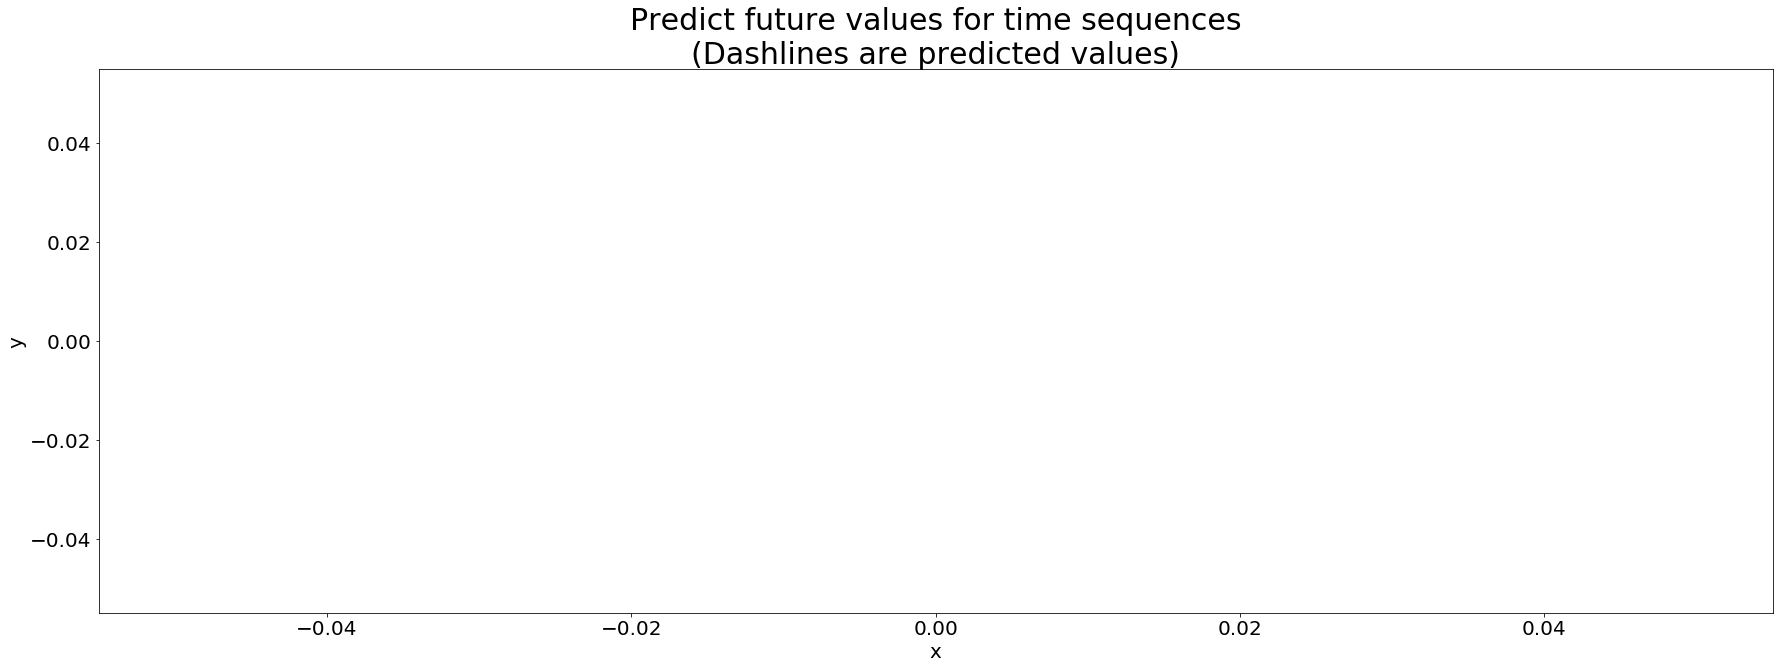

In [5]:
#begin to train
for i in range(15):
    
    
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('\rSTEP:', i,'loss:', loss.item(), end='')
        loss.backward()
        return loss
    optimizer.step(closure)
    
    future = 1000
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print(' test loss:', loss.item())
        y = pred.detach().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()
    #plt.close()